# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.data as td
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# CSV Exploration
Let's load up the csv and see what we got

In [3]:
df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
df.sample(5)

id_code  diagnosis
1338  5ce5eeaf757a          0
2783  c0202976c670          2
3459  f02babb3a023          0
2384  a70d0f12a641          0
781   382752f6694a          1

In [4]:
df.id_code.describe()

count             3662
unique            3662
top       39134907127a
freq                 1
Name: id_code, dtype: object

In [5]:
df.isna().sum()

id_code      0
diagnosis    0
dtype: int64

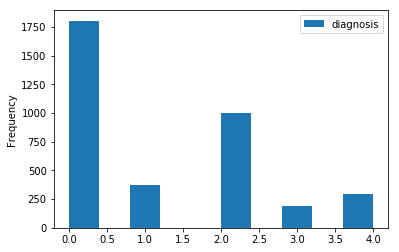

In [6]:
df.plot.hist(by='diagnosis')
plt.show()

Simple class labels. Nothing is missing, and there is a slight class imbalance. Now, let's check out the images

# Image Exploration
We'll define a dataset

In [7]:
oversampler = RandomOverSampler()

In [8]:
x,y = oversampler.fit_resample(df.id_code.values.reshape(-1,1),df.diagnosis.values)

In [9]:
df=pd.DataFrame({"id_code":x.flatten(),"diagnosis":y})

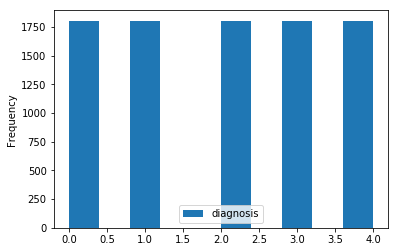

In [10]:
df.plot.hist(by='diagnosis')
plt.show()

In [11]:
imagePaths = df.apply(lambda x: '/kaggle/input/aptos2019-blindness-detection/train_images/'+str(x[0])+'.png',axis=1).values
classes = df.iloc[:,1].values

In [12]:
imagePaths[:10]

array(['/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/001639a390f0.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/0024cdab0c1e.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/002c21358ce6.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/005b95c28852.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/0083ee8054ee.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/0097f532ac9f.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/00a8624548a9.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/00b74780d31d.png',
       '/kaggle/input/aptos2019-blindness-detection/train_images/00cb6555d108.png'],
      dtype=object)

In [13]:
classes[:10]

array([2, 4, 1, 0, 0, 4, 0, 2, 2, 1])

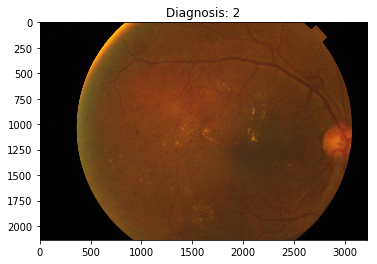

In [14]:
def load(path):
    image = tf.image.decode_png(tf.io.read_file(path),channels=3)
    return image
with tf.Session() as sess:
    image,label = sess.run(load(imagePaths[0])),classes[0]
plt.imshow(image)
plt.title('Diagnosis: '+str(label))
plt.show()

In [15]:
pathDS = td.Dataset.from_tensor_slices(imagePaths)

In [16]:
labelDS = td.Dataset.from_tensor_slices(classes)

In [17]:
def oneHotter(label):
    return tf.one_hot(label,5)

oneHotLabelDS = labelDS.map(oneHotter,num_parallel_calls=AUTOTUNE)

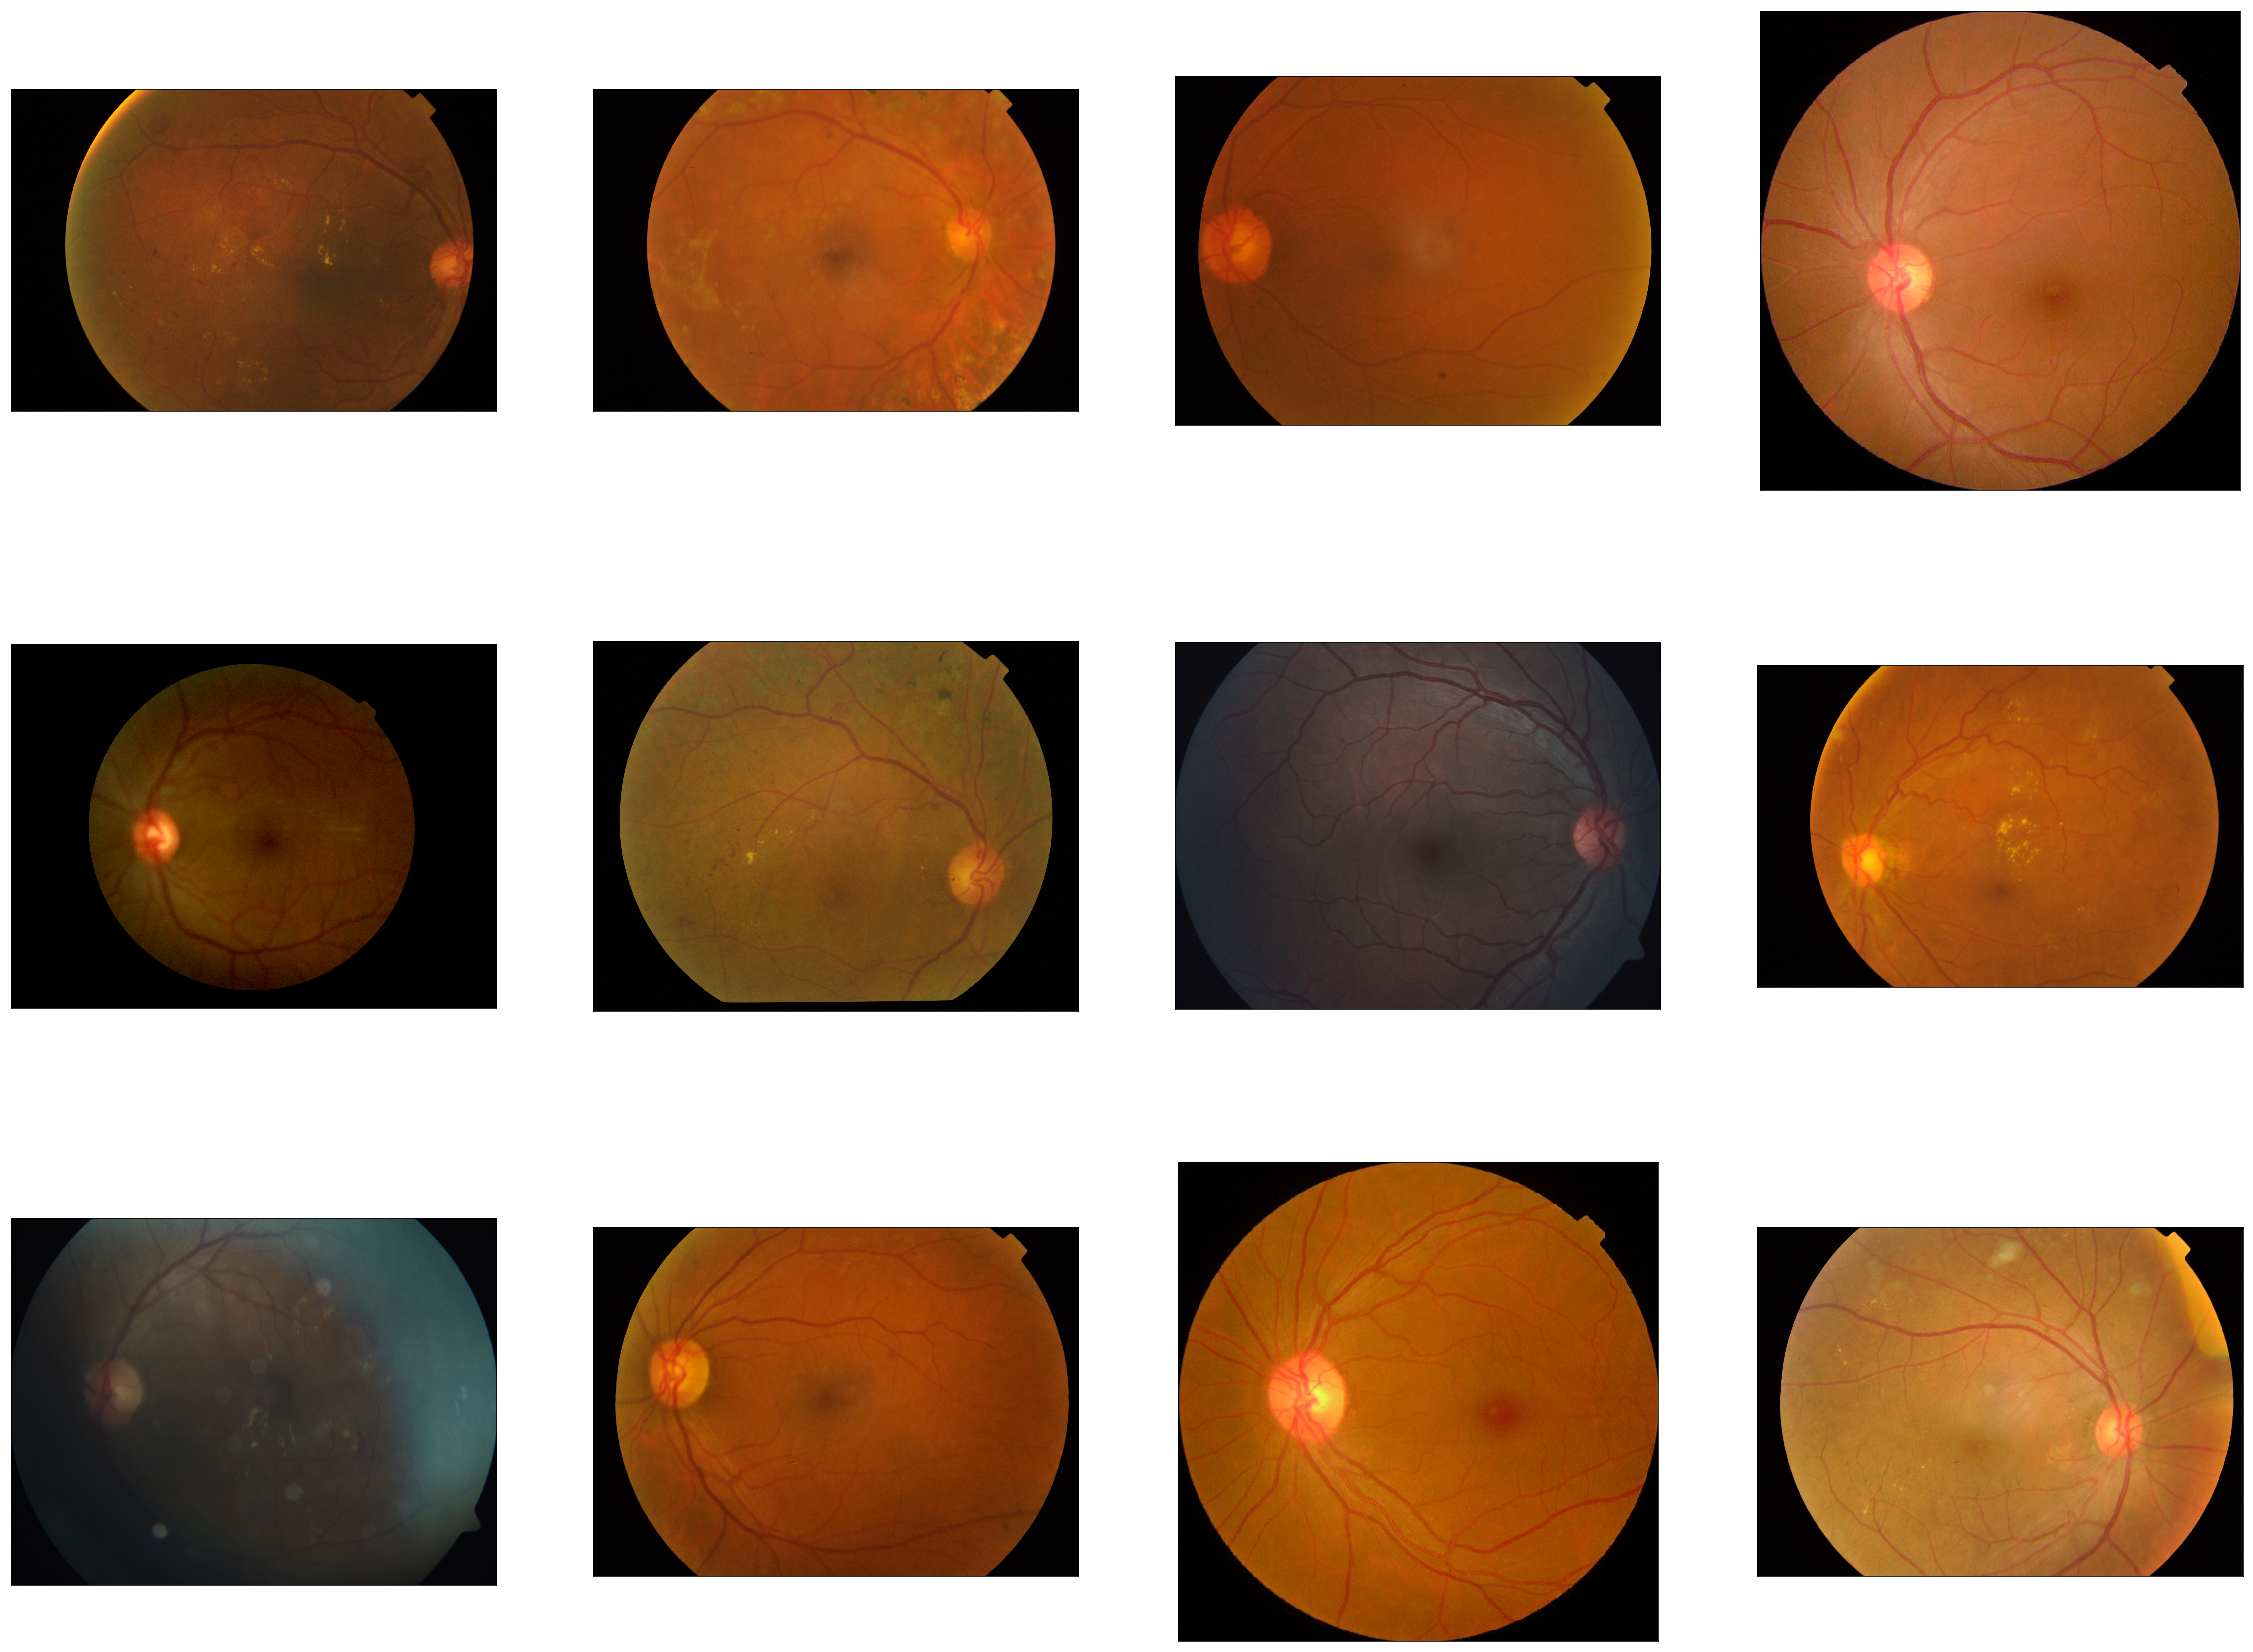

In [18]:
imageDSIterator = pathDS.map(load,num_parallel_calls=AUTOTUNE).make_one_shot_iterator()
elem = imageDSIterator.get_next()
with tf.Session() as sess:
    plt.figure(figsize=(40,30))
    for idx in range(12):
        image=sess.run(elem)
        plt.subplot(3,4,idx+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [19]:
def transform_perspective(image):
    def x_y_1():
        x = tf.random_uniform([], minval=-0.3, maxval=-0.15)
        y = tf.random_uniform([], minval=-0.3, maxval=-0.15)
        return x, y
     
    def x_y_2():
        x = tf.random_uniform([], minval=0.15, maxval=0.3)
        y = tf.random_uniform([], minval=0.15, maxval=0.3)
        return x, y       

    def trans(image):
        ran = tf.random_uniform([])
        x = tf.random_uniform([], minval=-0.3, maxval=0.3)
        x_com = tf.random_uniform([], minval=1-x-0.1, maxval=1-x+0.1)

        y = tf.random_uniform([], minval=-0.3, maxval=0.3)
        y_com = tf.random_uniform([], minval=1-y-0.1, maxval=1-y+0.1)

        transforms =  [x_com, x,0,y,y_com,0,0.00,0]

        ran = tf.random_uniform([]) 
        image = tf.cond(ran<0.5, lambda:tf.contrib.image.transform(image,transforms,interpolation='NEAREST', name=None), 
                lambda:tf.contrib.image.transform(image,transforms,interpolation='BILINEAR', name=None))
        return image

    ran = tf.random_uniform([])
    image = tf.cond(ran<1, lambda: trans(image), lambda:image)

    return image

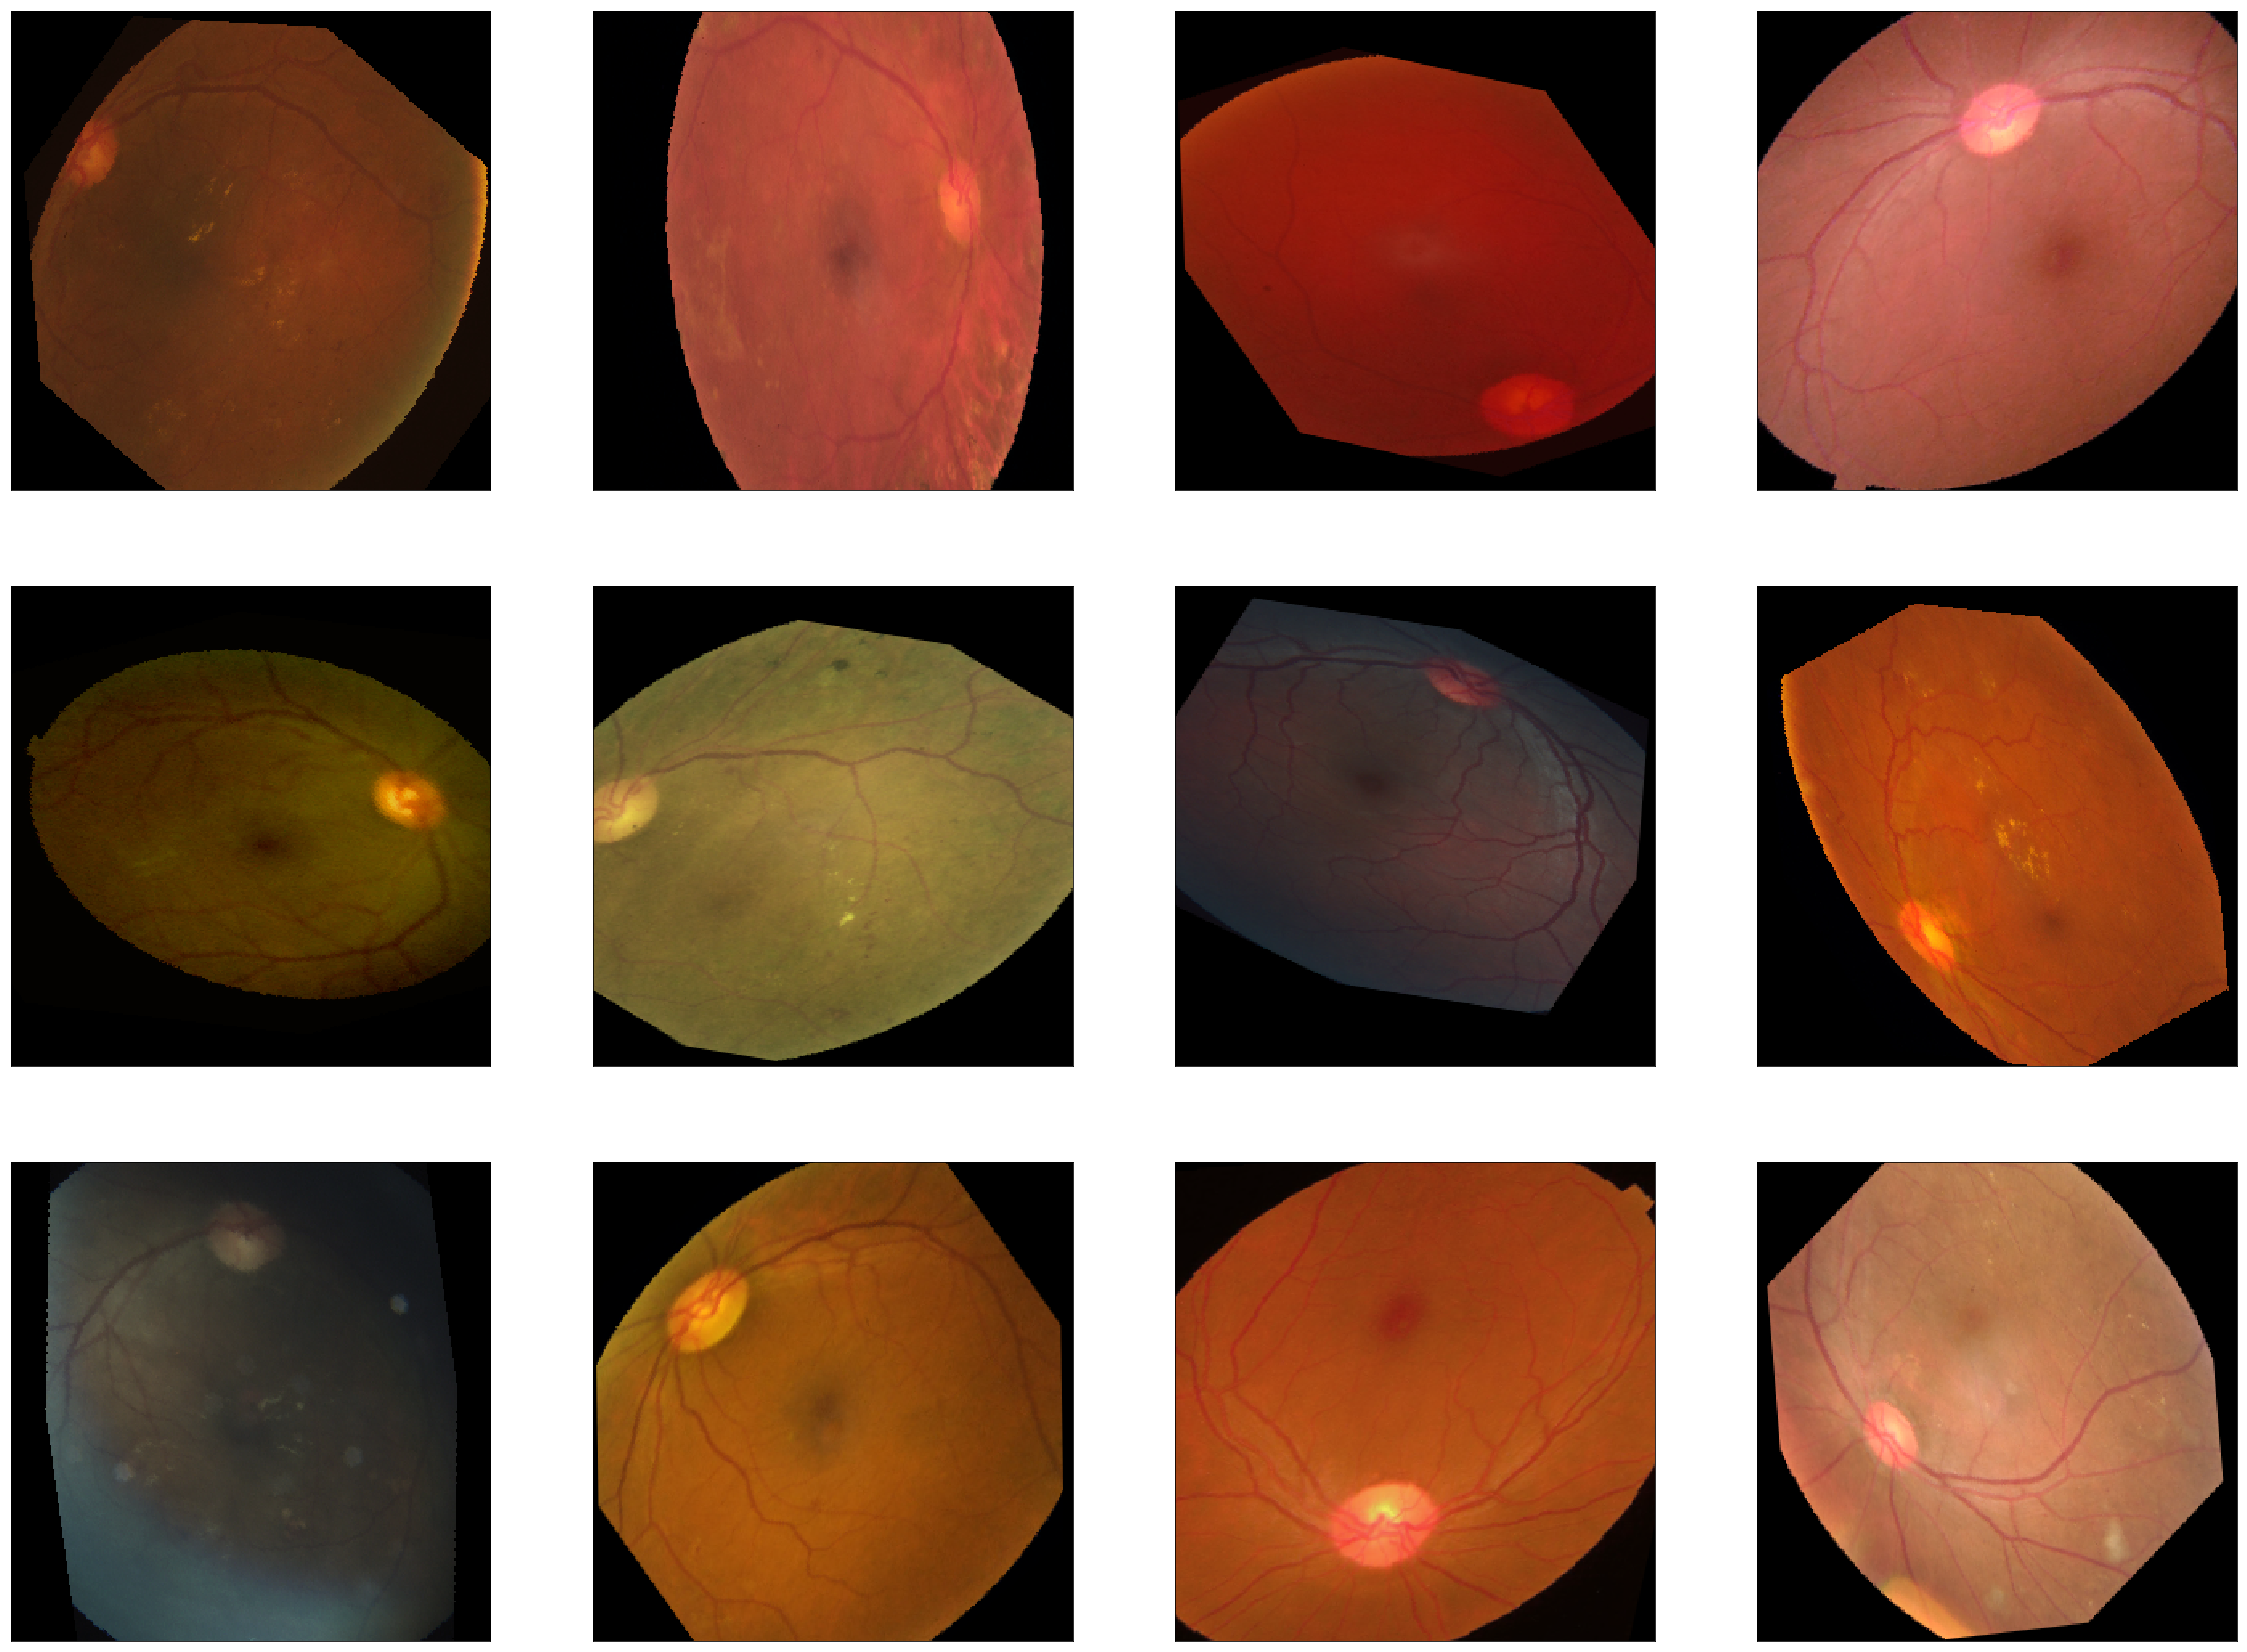

In [20]:
def loadAndPreProcess(path):
    image = tf.image.decode_png(tf.io.read_file(path),channels=3)
    image = tf.image.resize(image,[299,299])
    image = tf.image.random_brightness(image,0.5)
    image = tf.image.random_hue(image,0.05)
    image = tf.image.random_contrast(image,0.75,1.25)
    image = tf.image.random_saturation(image,0.75,1.25)
    image = tf.image.random_flip_left_right(image)
    image = tf.contrib.image.rotate(image,tf.random_uniform(shape=[], minval=-15, maxval=15, dtype=tf.float32))
    image = transform_perspective(image)
    image /= 255.
    image-=0.5
    image*=2.
    return image
    
augImageDS = pathDS.map(loadAndPreProcess,num_parallel_calls=AUTOTUNE)
augImageDSIterator = augImageDS.make_one_shot_iterator()
elem = augImageDSIterator.get_next()
with tf.Session() as sess:
    plt.figure(figsize=(40,30))
    for idx in range(12):
        image = sess.run(elem)
        plt.subplot(3,4,idx+1)
        plt.imshow(image/2+0.5)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [21]:
dataset = td.Dataset.zip((augImageDS,oneHotLabelDS))

In [22]:
batchSize=2
ds = dataset.shuffle(buffer_size=len(imagePaths)//10)
ds = ds.repeat()
ds = ds.batch(batchSize)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds = ds.make_one_shot_iterator()

In [23]:
print(ds)

In [24]:
base = tf.keras.applications.InceptionResNetV2(input_shape=(299,299,3),include_top=False,weights='imagenet')

219062272/219055592 [==============================] - 11s 0us/step


In [25]:
base.trainable=False
base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [26]:
model = tf.keras.Sequential([base,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(5)])

model.compile(optimizer=tf.train.AdamOptimizer(),loss=tf.losses.softmax_cross_entropy,metrics=['accuracy'])

In [27]:


model.fit(ds,epochs=20,verbose=1,steps_per_epoch=len(imagePaths)//batchSize)

Epoch 1/20
4512/4512 [==============================] - 1123s 249ms/step - loss: 1.0174 - acc: 0.6117
Epoch 2/20
4512/4512 [==============================] - 1020s 226ms/step - loss: 1.0224 - acc: 0.6137
Epoch 3/20
2686/4512 [================>.............] - ETA: 6:36 - loss: 1.1099 - acc: 0.5726

In [28]:
model.save('EyeClassifier')